# Vehicle Detection and Tracking Project

### Import needed data

In [1]:
import os
import cv2
import math
import numpy as np
from random import randint
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Define data set image paths for both positive and negative domains

In [2]:
Veh_Imgs_Path = "./../udacity_dataset/vehicles/vehicles/"
NonVeh_Imgs_Path = "./../udacity_dataset/non_vehicles/non_vehicles/"

Veh_Imgs = os.listdir(Veh_Imgs_Path)
NonVeh_Imgs = os.listdir(NonVeh_Imgs_Path)

### Collect Data set images

In [3]:
def CollectImages(folderpath, ImagePaths, isLabeled = True):
    images = []
    for ImagePath in ImagePaths:
        if (len(ImagePath.split('.')) == 2):
            im = cv2.imread(folderpath + ImagePath)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            #print('Image ' , ImagePath , ' is: ', type(im), ' with dimensions: ', im.shape)
            if isLabeled == True:
                images.append((im, ImagePath.split('.')[0]))
            else:
                images.append(im)
        else:
            print('Image', ImagePath, 'is correupted --> Discarded.')

    return images

In [4]:
CarImageSet = []
NonCarImageSet = []

for folder in Veh_Imgs:
    folderpath = Veh_Imgs_Path + folder
    Carsimagespath = os.listdir(folderpath)
    CarImageSet.append(CollectImages(folderpath + '/', Carsimagespath, True))

for folder in NonVeh_Imgs:
    folderpath = NonVeh_Imgs_Path + folder
    NonCarsimagespath = os.listdir(folderpath)
    NonCarImageSet.append(CollectImages(folderpath + '/', NonCarsimagespath, True))

CarImageSet = np.concatenate(CarImageSet)
NonCarImageSet = np.concatenate(NonCarImageSet)

print('Car Image Set has ', str(len(CarImageSet)))
print('Non Car Image Set has ', str(len(NonCarImageSet)))

Car Image Set has  8792
Non Car Image Set has  8968


### Define to access both image pixel values and labels

In [5]:
imgPxlVal = 0
img_Label = 1

## Visualize DataSet

In [6]:
def pltImages(images, labels, nrows = 1, ncols = 2, fig_w = 20, fig_h = 10, isgray = False):
    #below code is inspired from https://stackoverflow.com/questions/17111525/how-to-show-multiple-images-in-one-figure
    assert len(images) == len(labels)
    assert len(images) <= (nrows * ncols)
    
    fig = plt.figure(figsize=(fig_w, fig_h))
    
    for index in range(len(images)):
        plot = fig.add_subplot(nrows,ncols,index+1)
        plot.set_title(labels[index])
        if(isgray == False):
            plt.imshow(images[index].squeeze())
        else:
            plt.imshow(images[index].squeeze(), cmap='gray')
    
    plt.tight_layout()
    plt.show()

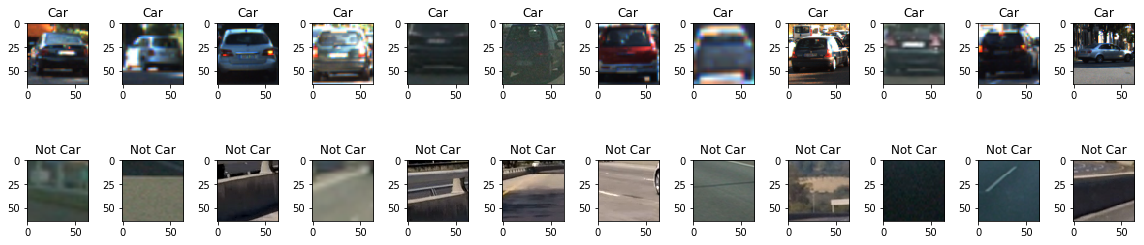

In [7]:
vis_imgs = []
vis_labels = []

#show 12 random images from Car dataset
for i in range(12):
    index = randint(0, len(CarImageSet))
    vis_imgs.append(CarImageSet[index][imgPxlVal])
    vis_labels.append('Car')

#show 12 random images from Not Car dataset
for i in range(12):
    index = randint(0, len(NonCarImageSet))
    vis_imgs.append(NonCarImageSet[index][imgPxlVal])
    vis_labels.append('Not Car')

pltImages(vis_imgs, vis_labels, 2, 12, 16, 4)

### Visualize color space features using histograms

In [8]:
def pltHistograms(hists, labels, nrows = 1, ncols = 2, fig_w = 20, fig_h = 10, xlim = [0,256]):
    assert len(hists) == len(labels)
    assert len(hists) <= (nrows * ncols)
    
    fig = plt.figure(figsize=(fig_w, fig_h))
    
    for index in range(len(hists)):
        plot = fig.add_subplot(nrows,ncols,index+1)
        plot.set_title(labels[index])
        plt.plot(hists[index])
        plt.xlim(xlim)
    
    plt.tight_layout()
    plt.show()

In [9]:
Channel_0 = 0
Channel_1 = 1
Channel_2 = 2

histSize = [48]
histrange = [0,255]

ColorSpace = ['RGB','HSV','HLS', 'LAB', 'YUV', 'LUV', 'YCrCb']

In [10]:
def ExploreColorSpaceHistogram(img):
    hist = []
    hist_label = []

    hist_0 = cv2.calcHist(img,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(img,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(img,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("RGB_Channel 0")
    hist.append(hist_1)
    hist_label.append("RGB_Channel 1")
    hist.append(hist_2)
    hist_label.append("RGB_Channel 2")

    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    hist_0 = cv2.calcHist(HSV,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(HSV,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(HSV,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("HSV_Channel 0")
    hist.append(hist_1)
    hist_label.append("HSV_Channel 1")
    hist.append(hist_2)
    hist_label.append("HSV_Channel 2")

    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    hist_0 = cv2.calcHist(HLS,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(HLS,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(HLS,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("HLS_Channel 0")
    hist.append(hist_1)
    hist_label.append("HLS_Channel 1")
    hist.append(hist_2)
    hist_label.append("HLS_Channel 2")

    LAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    hist_0 = cv2.calcHist(LAB,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(LAB,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(LAB,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("LAB_Channel 0")
    hist.append(hist_1)
    hist_label.append("LAB_Channel 1")
    hist.append(hist_2)
    hist_label.append("LAB_Channel 2")

    YUV = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    hist_0 = cv2.calcHist(YUV,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(YUV,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(YUV,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("YUV_Channel 0")
    hist.append(hist_1)
    hist_label.append("YUV_Channel 1")
    hist.append(hist_2)
    hist_label.append("YUV_Channel 2")

    LUV = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

    hist_0 = cv2.calcHist(LUV,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(LUV,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(LUV,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("LUV_Channel 0")
    hist.append(hist_1)
    hist_label.append("LUV_Channel 1")
    hist.append(hist_2)
    hist_label.append("LUV_Channel 2")
    
    YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    hist_0 = cv2.calcHist(YCrCb,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(YCrCb,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(YCrCb,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("YCrCb_Channel 0")
    hist.append(hist_1)
    hist_label.append("YCrCb_Channel 1")
    hist.append(hist_2)
    hist_label.append("YCrCb_Channel 2")

    pltHistograms(hist, hist_label, 7, 3, xlim = [0, histSize[0]-1])

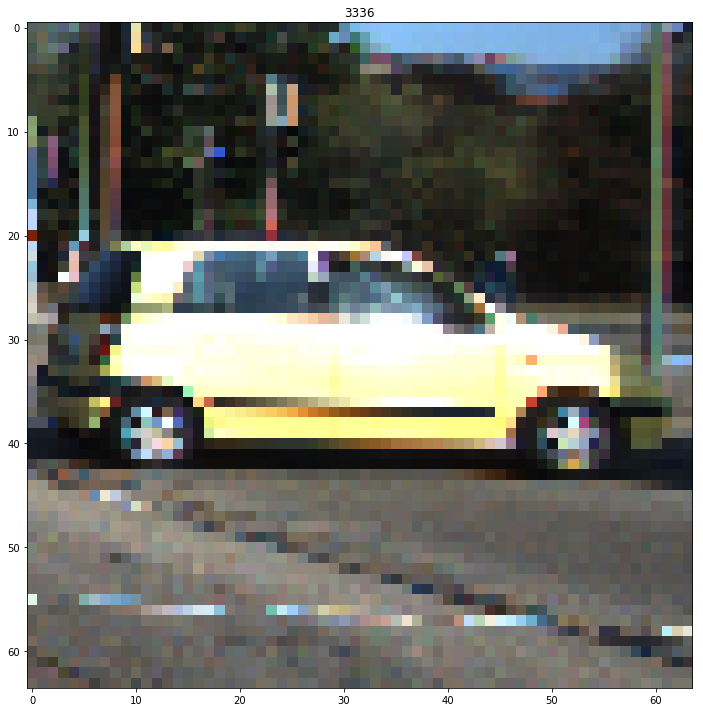

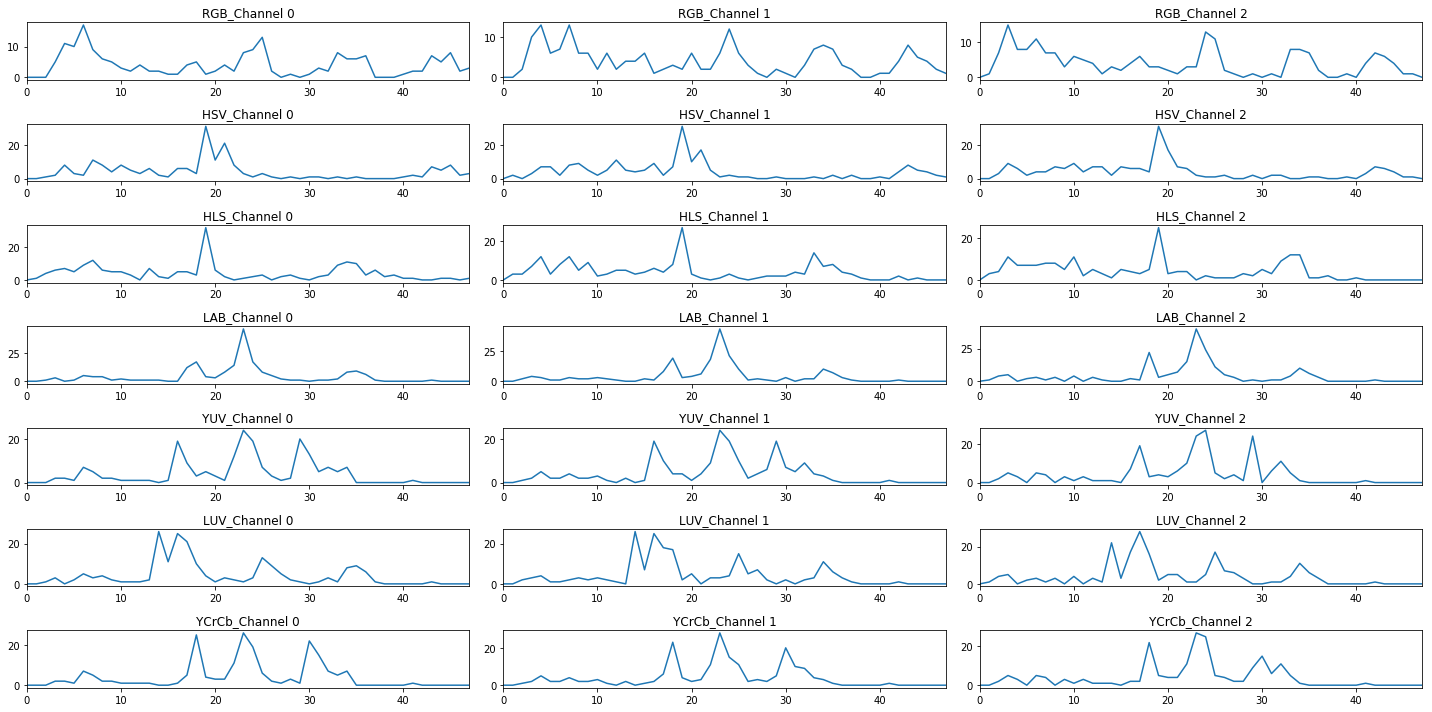

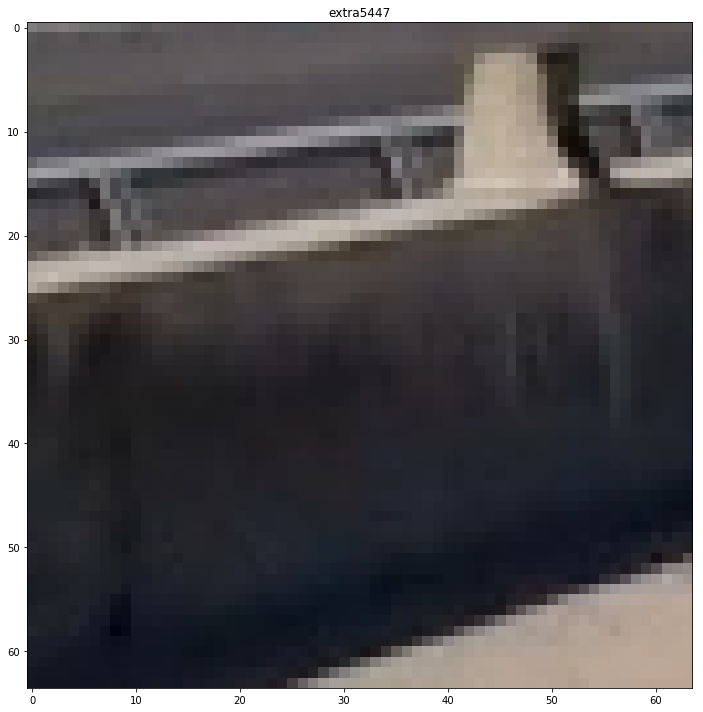

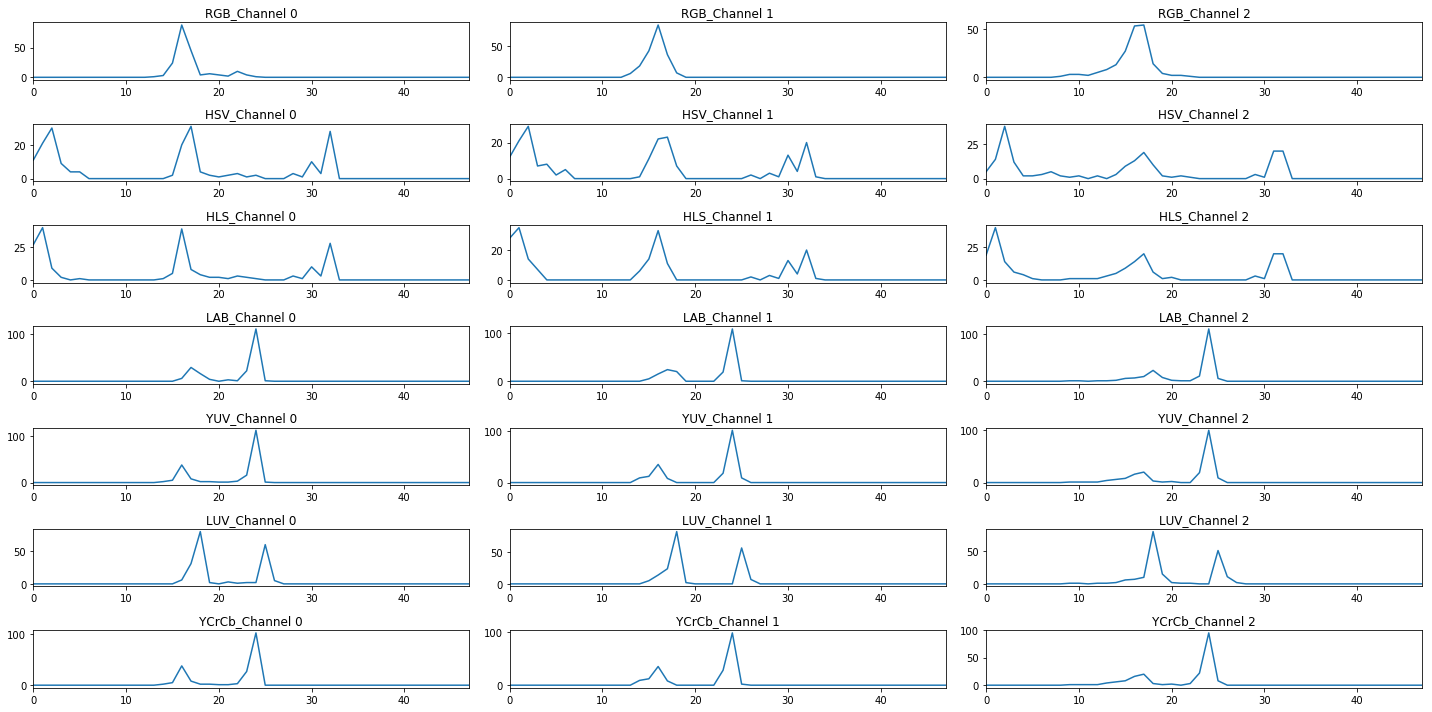

In [11]:
#CarImageIndex = 0
CarImageIndex = randint(0, len(CarImageSet))
CarImage = [CarImageSet[CarImageIndex][imgPxlVal]]
CarImageLavel = [CarImageSet[CarImageIndex][img_Label]]

pltImages(CarImage, CarImageLavel, 1, 1)
ExploreColorSpaceHistogram(CarImage[0])

#NonCarImageIndex = 0
NonCarImageIndex = randint(0, len(NonCarImageSet))
NonCarImage = [NonCarImageSet[NonCarImageIndex][imgPxlVal]]
NonCarImageLabel = [NonCarImageSet[NonCarImageIndex][img_Label]]

pltImages(NonCarImage, NonCarImageLabel, 1, 1)
ExploreColorSpaceHistogram(NonCarImage[0])

Spatial Binning

In [12]:
#Code obtained from Udacity lesson 16
def bin_spatial_Demo_colorspace(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'LAB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [13]:
size=(32, 32)

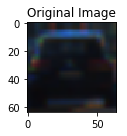

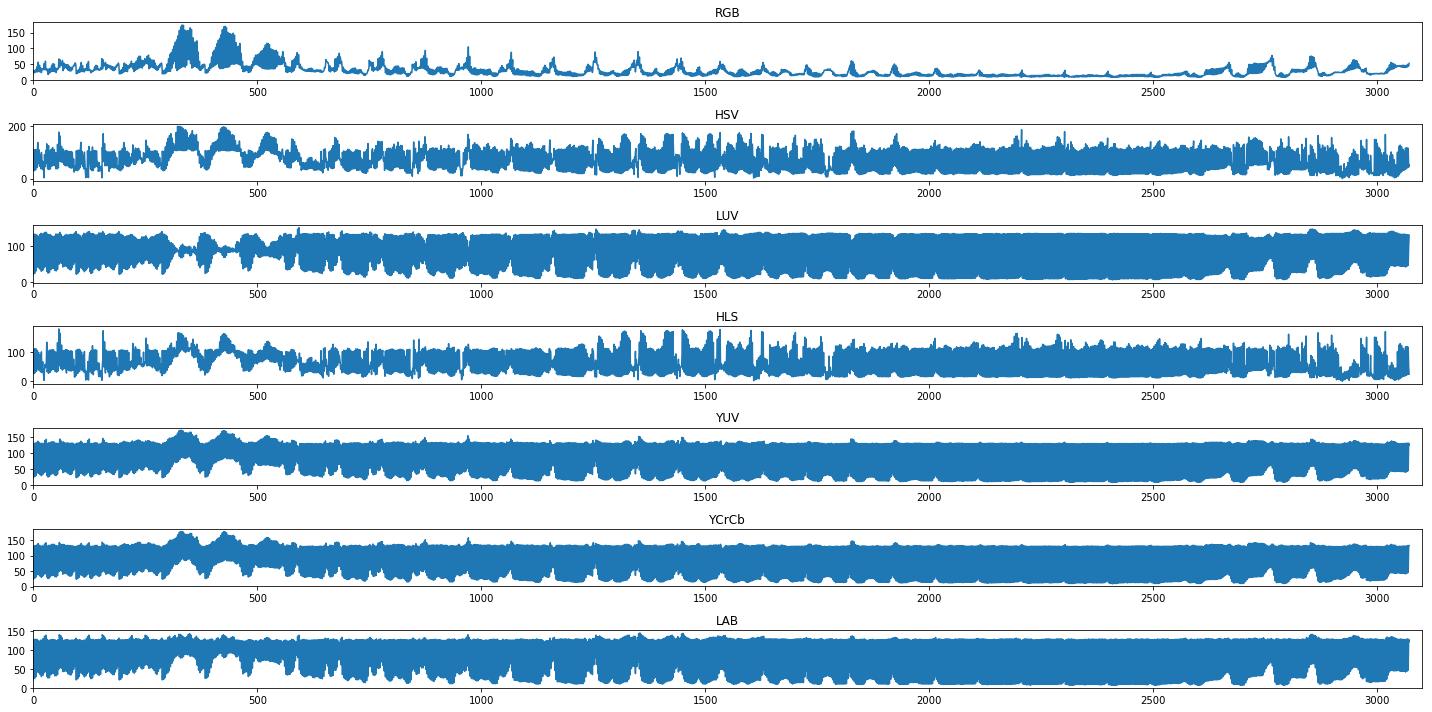

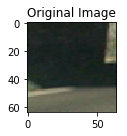

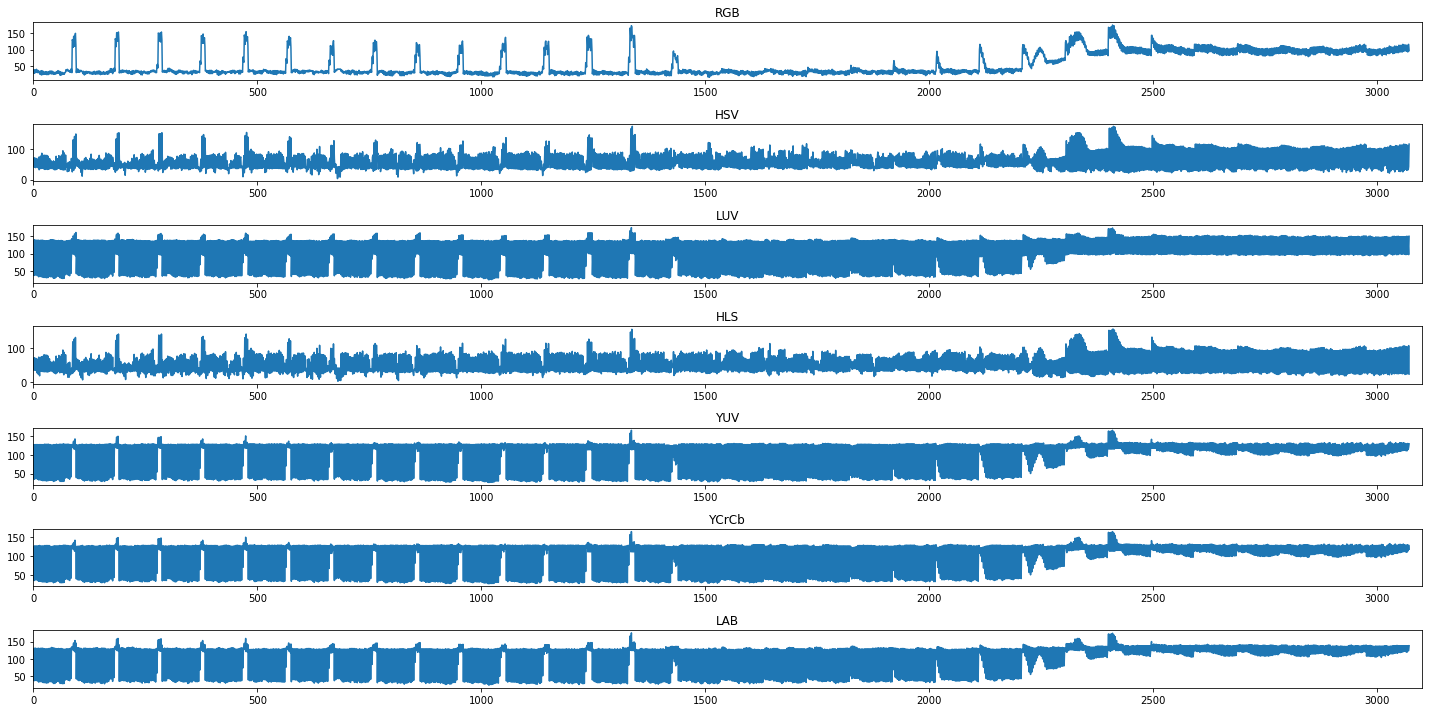

In [14]:
vis_imgs = []
vis_labels = []

index = randint(0, len(CarImageSet))

vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], size=size))
vis_labels.append('RGB')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='HSV', size=size))
vis_labels.append('HSV')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='LUV', size=size))
vis_labels.append('LUV')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='HLS', size=size))
vis_labels.append('HLS')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='YUV', size=size))
vis_labels.append('YUV')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='YCrCb', size=size))
vis_labels.append('YCrCb')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='LAB', size=size))
vis_labels.append('LAB')

pltImages([CarImageSet[index][imgPxlVal]], ["Original Image"], 1, 1, 20, 2)
pltHistograms(vis_imgs, vis_labels, 7, 1, xlim = [0, 3100])

vis_imgs = []
vis_labels = []

index = randint(0, len(NonCarImageSet))

vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], size=size))
vis_labels.append('RGB')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='HSV', size=size))
vis_labels.append('HSV')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='LUV', size=size))
vis_labels.append('LUV')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='HLS', size=size))
vis_labels.append('HLS')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='YUV', size=size))
vis_labels.append('YUV')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='YCrCb', size=size))
vis_labels.append('YCrCb')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='LAB', size=size))
vis_labels.append('LAB')

pltImages([NonCarImageSet[index][imgPxlVal]], ["Original Image"], 1, 1, 20, 2)
pltHistograms(vis_imgs, vis_labels, 7, 1, xlim = [0, 3100])

### Visualize HOG features

In [16]:
def get_hog_features_demo(img, orient, pix_per_cell, cell_per_block, block_norm, multichannel, vis=False, feature_vec=True):
    
    return hog(
                img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                cells_per_block=(cell_per_block, cell_per_block), block_norm=block_norm,
                visualise=vis, multichannel=multichannel, feature_vector=feature_vec
              )

In [17]:
orient = 12
pix_per_cell = 12
cells_per_block = 2

blockNorm = ['L1', 'L1-sqrt', 'L2', 'L2-Hys']

hc = 'ALL'

In [18]:
vis_imgs = []
vis_labels = []

index = randint(0, len(CarImageSet))
print(CarImageSet[index][imgPxlVal].shape)
_, hog_im = get_hog_features_demo(CarImageSet[index][imgPxlVal], orient, pix_per_cell, cells_per_block, 'L2-Hys', True, True)
vis_imgs.append(hog_im)
vis_labels.append('Car')

(64, 64, 3)


NameError: name '_hoghistogram' is not defined